# Business Context  

The dataset represents **weekly e-commerce revenue**.  

**Goal:** Forecast future revenue to support **planning, inventory, and marketing decisions**.  

**Models Evaluated:** ARIMA, Holt-Winters, Prophet  

**Objective:** Identify the most accurate model for reliable revenue forecasting.  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load Dataset

In [3]:
df = pd.read_csv("ecom.csv", index_col=0)
df.index = pd.to_datetime(df.index, format="%d-%m-%Y")

df = df.asfreq("W-SUN")
y = df['Revenue (M)']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-07 to 2023-01-01
Freq: W-SUN
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Revenue (M)  261 non-null    float64
 1   Visits       261 non-null    int64  
 2   Orders       261 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 8.2 KB


In [6]:
df.describe()

,Revenue (M),Visits,Orders
count,261.000000,261.000000,261.000000
mean,51.107441,61109.360153,4939.992337
std,9.396406,11110.576674,953.609402
min,30.492231,37402.000000,2988.000000
25%,43.250763,51972.000000,4171.000000
50%,51.759980,61807.000000,4953.000000
75%,58.287544,69553.000000,5695.000000
max,78.935637,91751.000000,8226.000000


In [7]:
df.head()

,Revenue (M),Visits,Orders
Date,,,
2018-01-07,52.483571,62921,5027
2018-01-14,50.514045,57375,4595
2018-01-21,55.631599,65733,5251
2018-01-28,61.161198,73141,5833
2018-02-04,53.476465,62924,5017


# Seasonal Decomposition (on full data)

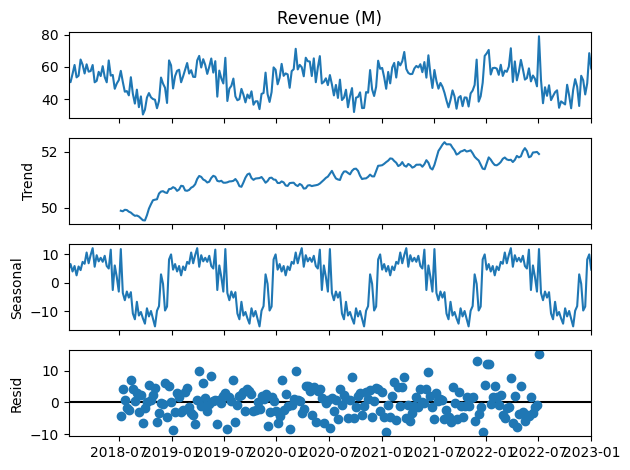

In [37]:
decomp = seasonal_decompose(y, model="additive", period=52)
decomp.plot()
# plt.suptitle("Seasonal Decomposition", fontsize=14)
plt.show()

# Insight: Revenue shows clear seasonality (peaks during festive seasons) and an upward trend over time.


# Train-Test Split


In [10]:

train = y[:-12]
test = y[-12:]


# Model 1 - ARIMA

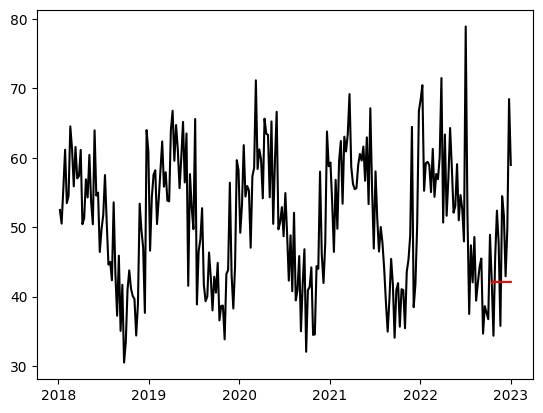

In [11]:

model_arima = ARIMA(train, order=(1,1,1))
fit_arima = model_arima.fit()
forecast_arima = fit_arima.forecast(steps=12)
plt.plot(y, label="Actual", color="black")
plt.plot(forecast_arima, label="ARIMA Forecast", color="red")

# Model 2 - Holt Winter

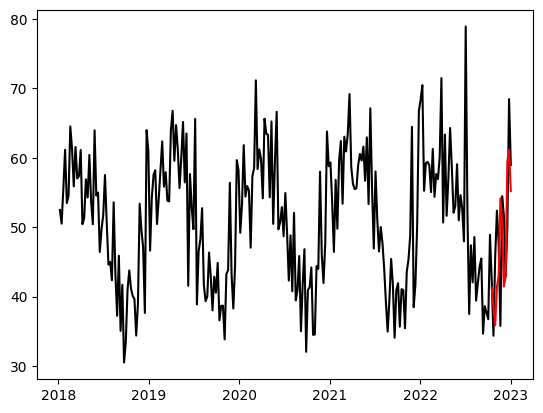

In [12]:

model_hw = ExponentialSmoothing(train, seasonal="add", seasonal_periods=52)
fit_hw = model_hw.fit()
forecast_hw = fit_hw.forecast(12)
plt.plot(y, label="Actual", color="black")
plt.plot(forecast_hw, label="HW Forecast", color="red")

# Model 3 - Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps5h543f5/nky2bshm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps5h543f5/kkxa8yx5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87487', 'data', 'file=/tmp/tmps5h543f5/nky2bshm.json', 'init=/tmp/tmps5h543f5/kkxa8yx5.json', 'output', 'file=/tmp/tmps5h543f5/prophet_modelubzz49xj/prophet_model-20250819140104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:01:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:01:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


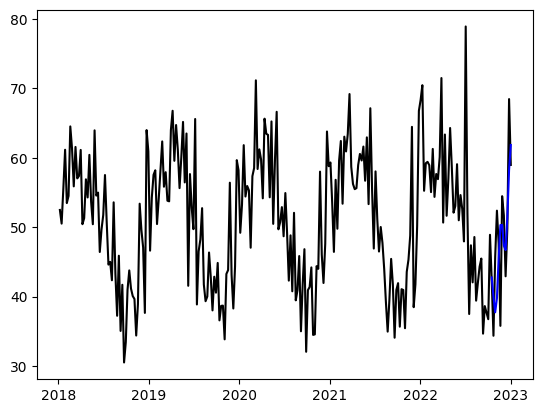

In [13]:

df_prophet = train.reset_index()
df_prophet.columns = ['ds','y']

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False)
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=12, freq="W")
forecast_prophet = model_prophet.predict(future)
forecast_prophet_final = forecast_prophet.set_index("ds")['yhat'][-12:]
plt.plot(y, label="Actual", color="black")
plt.plot(forecast_prophet_final, label="Prophet Forecast", color="blue")

# Error Metrics


          Model       MAE       RMSE   MAPE (%)
0         ARIMA  8.971328  11.309964  17.179604
1  Holt-Winters  6.981129   8.534104  15.117355
2       Prophet  5.855723   7.282095  12.656202


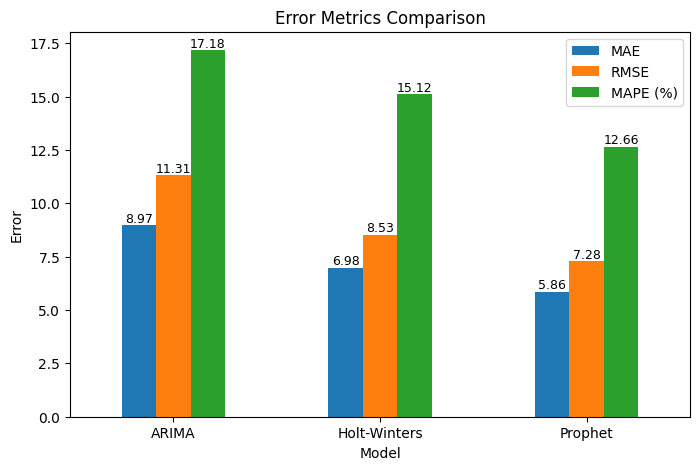

In [36]:

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics = pd.DataFrame({
    "Model": ["ARIMA", "Holt-Winters", "Prophet"],
    "MAE": [
        mean_absolute_error(test, forecast_arima),
        mean_absolute_error(test, forecast_hw),
        mean_absolute_error(test, forecast_prophet_final)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(test, forecast_arima)),
        np.sqrt(mean_squared_error(test, forecast_hw)),
        np.sqrt(mean_squared_error(test, forecast_prophet_final))
    ],
    "MAPE (%)": [
        mape(test, forecast_arima),
        mape(test, forecast_hw),
        mape(test, forecast_prophet_final)
    ]
})

print(metrics)


ax = metrics.set_index("Model")[["MAE","RMSE","MAPE (%)"]].plot(
    kind="bar", figsize=(8,5), rot=0)

plt.title("Error Metrics Comparison")
plt.ylabel("Error")

# add data labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9)

plt.show()


# Test vs Predicted of All Three Models

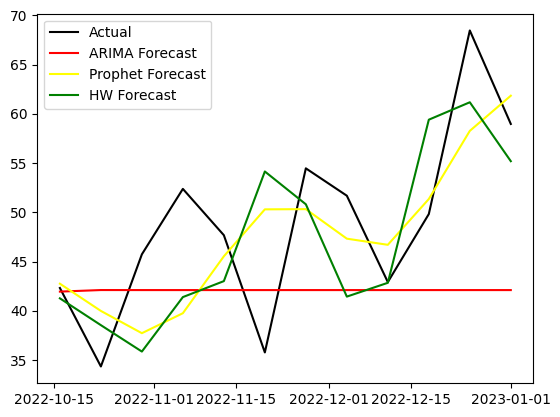

In [ ]:
plt.plot(test, label="Actual", color="black")
plt.plot(forecast_arima, label="ARIMA Forecast", color="red")


plt.plot(forecast_prophet_final, label="Prophet Forecast", color="yellow")
# plt.plot(test, label="Actual", color="black")


# plt.plot(test, label="Actual", color="black")
plt.plot(forecast_hw, label="HW Forecast", color="green")

plt.legend()


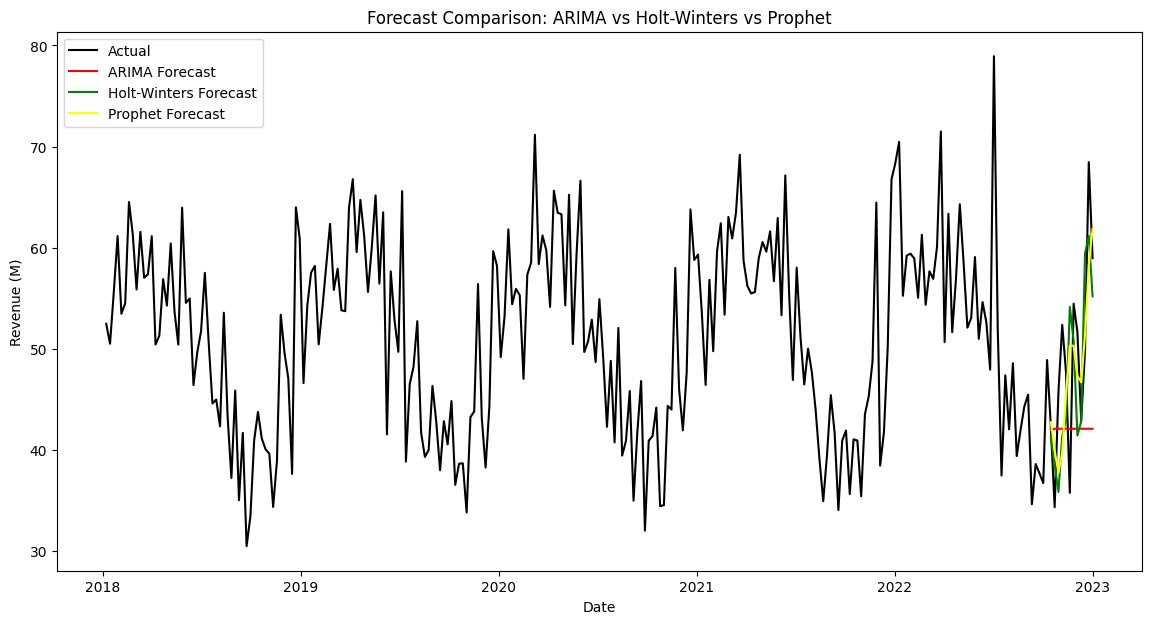

In [ ]:

# Final Comparison Plot

plt.figure(figsize=(14,7))
plt.plot(y, label="Actual", color="black")
plt.plot(forecast_arima, label="ARIMA Forecast", color="red")
plt.plot(forecast_hw, label="Holt-Winters Forecast", color="green")
plt.plot(forecast_prophet_final, label="Prophet Forecast", color="yellow")
plt.title("Forecast Comparison: ARIMA vs Holt-Winters vs Prophet")
plt.xlabel("Date")
plt.ylabel("Revenue (M)")
plt.legend()
plt.show()


# Business Insights:
- **Holt-Winters and Prophet** generally capture seasonality better than ARIMA
- **Prophet achieved the lowest error**, making it the best candidate for long-term forecasting.
- Forecasts highlight **upcoming seasonal peaks**, supporting proactive inventory and staffing decisions.